<a href="https://colab.research.google.com/github/Shripad1020/Image-Caption-Suggester/blob/main/Image_Caption_Suggester.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')
#!ls "/content/drive/My Drive"

Mounted at /content/drive


In [ ]:
import numpy as np
import cv2
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import string
import seaborn as sns
from collections import Counter
import os
import nltk
from nltk.corpus import stopwords
from PIL import Image
import glob
import pickle
from time import time
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import add
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras import Input, layers
from tensorflow.keras import optimizers
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

In [ ]:
def rename(folder):
	for count, filename in enumerate(os.listdir(folder)):
		dst = "Edi_" + str(count) + ".jpg"
		src = folder + filename
		dst = folder + dst

		os.rename(src, dst)

rename("/content/drive/MyDrive/EDI2021/New Img/")

In [ ]:
file_open = open("/content/drive/MyDrive/EDI2021/our_test.txt", "w")
folder = "/content/drive/MyDrive/EDI2021/Our_Test/"

for filename in os.listdir(folder):
    file_open.write(filename+"\n");
    
file_open.close()

In [ ]:
"""import sys

if len(sys.argv) > 1:
    file =sys.argv[1]
    if os.path.exists(file):
        filename=file.split(".")
        img = Image.open(file)
        target_name = filename[0] + ".jpg"
        rgb_image = img.convert('RGB')
        rgb_image.save(target_name)
        print("Converted image saved as " + target_name)
    else:
        print(file + " not found in given location")
else:
    print("please execute the script with input image as : python tqbimageconvert.py <file>")"""

'import sys\n\nif len(sys.argv) > 1:\n    file =sys.argv[1]\n    if os.path.exists(file):\n        filename=file.split(".")\n        img = Image.open(file)\n        target_name = filename[0] + ".jpg"\n        rgb_image = img.convert(\'RGB\')\n        rgb_image.save(target_name)\n        print("Converted image saved as " + target_name)\n    else:\n        print(file + " not found in given location")\nelse:\n    print("please execute the script with input image as : python tqbimageconvert.py <file>")'

In [ ]:
filename = "/content/drive/MyDrive/EDI2021/captions.txt"

def load_doc(filename):
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text

doc = load_doc(filename)

In [ ]:
df = pd.read_csv(filename)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40455 entries, 0 to 40454
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   image    40455 non-null  object
 1   caption  40455 non-null  object
dtypes: object(2)
memory usage: 632.2+ KB
None


In [ ]:
df.head(15)

image                                            caption
0   1000268201_693b08cb0e.jpg  A child in a pink dress is climbing up a set o...
1   1000268201_693b08cb0e.jpg              A girl going into a wooden building .
2   1000268201_693b08cb0e.jpg   A little girl climbing into a wooden playhouse .
3   1000268201_693b08cb0e.jpg  A little girl climbing the stairs to her playh...
4   1000268201_693b08cb0e.jpg  A little girl in a pink dress going into a woo...
5   1001773457_577c3a7d70.jpg         A black dog and a spotted dog are fighting
6   1001773457_577c3a7d70.jpg  A black dog and a tri-colored dog playing with...
7   1001773457_577c3a7d70.jpg  A black dog and a white dog with brown spots a...
8   1001773457_577c3a7d70.jpg  Two dogs of different breeds looking at each o...
9   1001773457_577c3a7d70.jpg    Two dogs on pavement moving toward each other .
10  1002674143_1b742ab4b8.jpg  A little girl covered in paint sits in front o...
11  1002674143_1b742ab4b8.jpg  A little girl is sitting in front of a large p...
12  1002674143_1b742ab4b8.jpg  A small girl in the grass plays with fingerpai...
13  1002674143_1b742ab4b8.jpg  There is a girl with pigtails sitting in front...
14  1002674143_1b742ab4b8.jpg  Young girl with pigtails painting outside in t...

In [ ]:
d = dict()
for i in range(0, 40455, 5):
    image_id = df['image'][i].split('.')[0]
    token = []
    for j in range(0, 5):
        token_dis = df['caption'][i+j].split()
        token_dis = ' '.join(token_dis)
        token.append(token_dis)
    d[image_id] = token

print(d['101654506_8eb26cfb60'])
#print(d['Edi_0'])

['A brown and white dog is running through the snow .', 'A dog is running in the snow', 'A dog running through snow .', 'a white and brown dog is running through a snow covered field .', 'The white and brown dog is running over the surface of the snow .']


In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
vocab_ = []
def get_vocabulary():
    for cap in df.caption.values:
        vocab_.extend(cap.split())
    print("Size of vocabulary", len(set(vocab_)))
    return vocab_

vocab = get_vocabulary()
value_count = Counter(vocab)

Size of vocabulary 9630


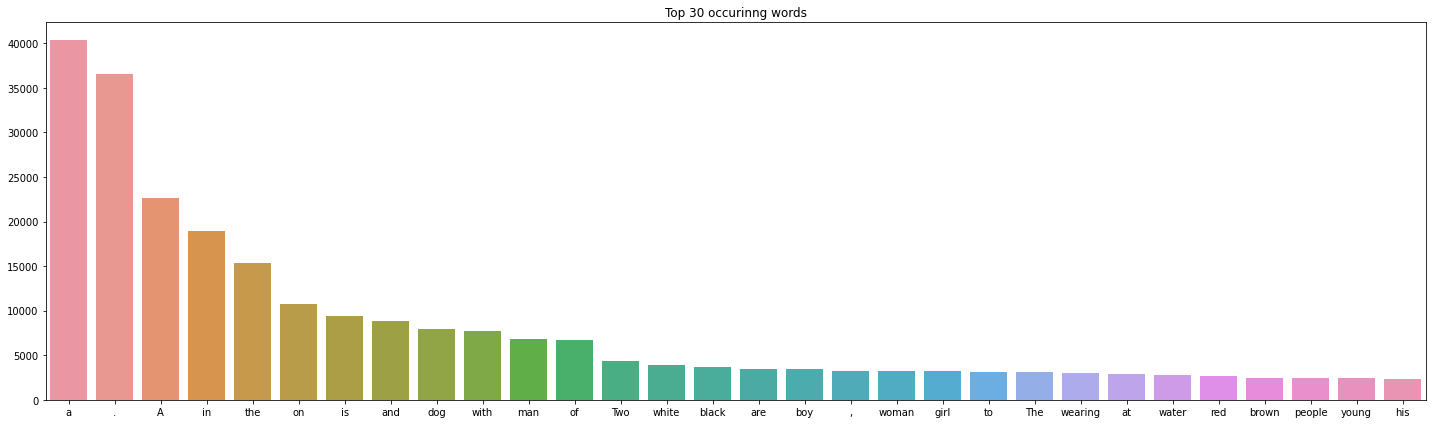

In [ ]:
sorted_list = value_count.most_common(30)
stop_word = set(stopwords.words('english'))

def plotWordCount(wordCountList):
    word_list,wc_list = [],[]
    for word, count in wordCountList:
        word_list.append(word)
        wc_list.append(count)
    plt.figure(figsize=(20,6))
    sns.barplot(x = word_list, y = wc_list, orient='v').set_title('Top 30 occurinng words')
    plt.tight_layout()

plotWordCount(sorted_list)

In [ ]:
def clean_desc(description):
    table = str.maketrans('', '', string.punctuation)
    for key, desc_list in d.items():
        for i in range(len(desc_list)):
            desc = desc_list[i]
            desc = desc.split()
            desc = [word.lower() for word in desc]
            desc = [w.translate(table) for w in desc]
            desc = [word for word in desc if len(word) > 1]
            desc = [word for word in desc if word.isalpha()]
            desc_list[i] =  ' '.join(desc)

clean_desc(d)

In [ ]:
print(d['101654506_8eb26cfb60'])
#print(d['Edi_0'])

['brown and white dog is running through the snow', 'dog is running in the snow', 'dog running through snow', 'white and brown dog is running through snow covered field', 'the white and brown dog is running over the surface of the snow']


In [ ]:
def to_vocabulary(description):
    all_desc = set()
    for key in description.keys():
        [all_desc.update(des.split()) for des in description[key]]
    return all_desc

vocabulary = to_vocabulary(d)
print("Vocabulary size: %d" %len(vocabulary))

Vocabulary size: 8763


In [ ]:
'''# Create a list of all the training captions
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)

# Consider only words which occur at least 10 times in the corpus
word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]'''


"# Create a list of all the training captions\nall_train_captions = []\nfor key, val in train_descriptions.items():\n    for cap in val:\n        all_train_captions.append(cap)\n\n# Consider only words which occur at least 10 times in the corpus\nword_count_threshold = 10\nword_counts = {}\nnsents = 0\nfor sent in all_train_captions:\n    nsents += 1\n    for w in sent.split(' '):\n        word_counts[w] = word_counts.get(w, 0) + 1\n\nvocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]"

In [ ]:
def save_desc(description, filename):
    lines = list()
    for key, desc_list in d.items():
        for desc in desc_list:
            lines.append(key + ' ' + desc)
    data = '\n'.join(lines)

    file = open(filename, 'w')
    file.write(data)
    file.close()

save_desc(d, "/content/drive/MyDrive/EDI2021/description.txt")

In [ ]:
def load_set(filename):
    doc = load_doc(filename)
    dataset = list()
    for line in doc.split('\n'):
        if len(line) < 1:
            continue
        identifier = line.split('.')[0]
        dataset.append(identifier)
    return set(dataset)

# load training dataset 
filename = "/content/drive/MyDrive/EDI2021/Flickr_8k.trainImages.txt"
#filename = "/content/drive/MyDrive/EDI2021/our_test.txt"
train = load_set(filename)
print('Dataset: %d' % len(train))

Dataset: 6000


In [ ]:
#all the images
images = "/content/drive/MyDrive/EDI2021/Images/"
#images = "/content/drive/MyDrive/EDI2021/Our_Test/"

img = glob.glob(images + '*.jpg')
print(len(img))

8092


In [ ]:
# train data
train_images_file = "/content/drive/MyDrive/EDI2021/Flickr_8k.trainImages.txt"
#train_images_file = "/content/drive/MyDrive/EDI2021/our_test.txt"

train_images = set(open(train_images_file, 'r').read().strip().split('\n'))

# list of all the training images with their full path names
train_img = []

for i in img:                               # img is list of full path names of all images
    if i[len(images):] in train_images:     # Check if the image belongs to training set
        train_img.append(i)                 # Add it to the list of train images

print(len(train_img))

6000


In [ ]:
# test data
test_images_file = "/content/drive/MyDrive/EDI2021/Flickr_8k.testImages.txt"

test_images = set(open(test_images_file, 'r').read().strip().split('\n'))

test_img = []

for i in img:                               
    if i[len(images):] in test_images:      
        test_img.append(i)       

print(len(test_img))        

1000


In [ ]:
def load_clean_descriptions(filename, dataset):
	# load document
	doc = load_doc(filename)
	descriptions = dict()
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		# split id from description
		image_id, image_desc = tokens[0], tokens[1:]
		# skip images not in the set
		if image_id in dataset:
			# create list
			if image_id not in descriptions:
				descriptions[image_id] = list()
			# wrap description in tokens
			desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
			# store
			descriptions[image_id].append(desc)
	return descriptions

# descriptions
train_descriptions = load_clean_descriptions("/content/drive/MyDrive/EDI2021/description.txt", train)
#train_descriptions = load_clean_descriptions("/content/drive/MyDrive/EDI2021/our_description.txt", train)
print('Descriptions: train = %d' % len(train_descriptions))

Descriptions: train = 6000


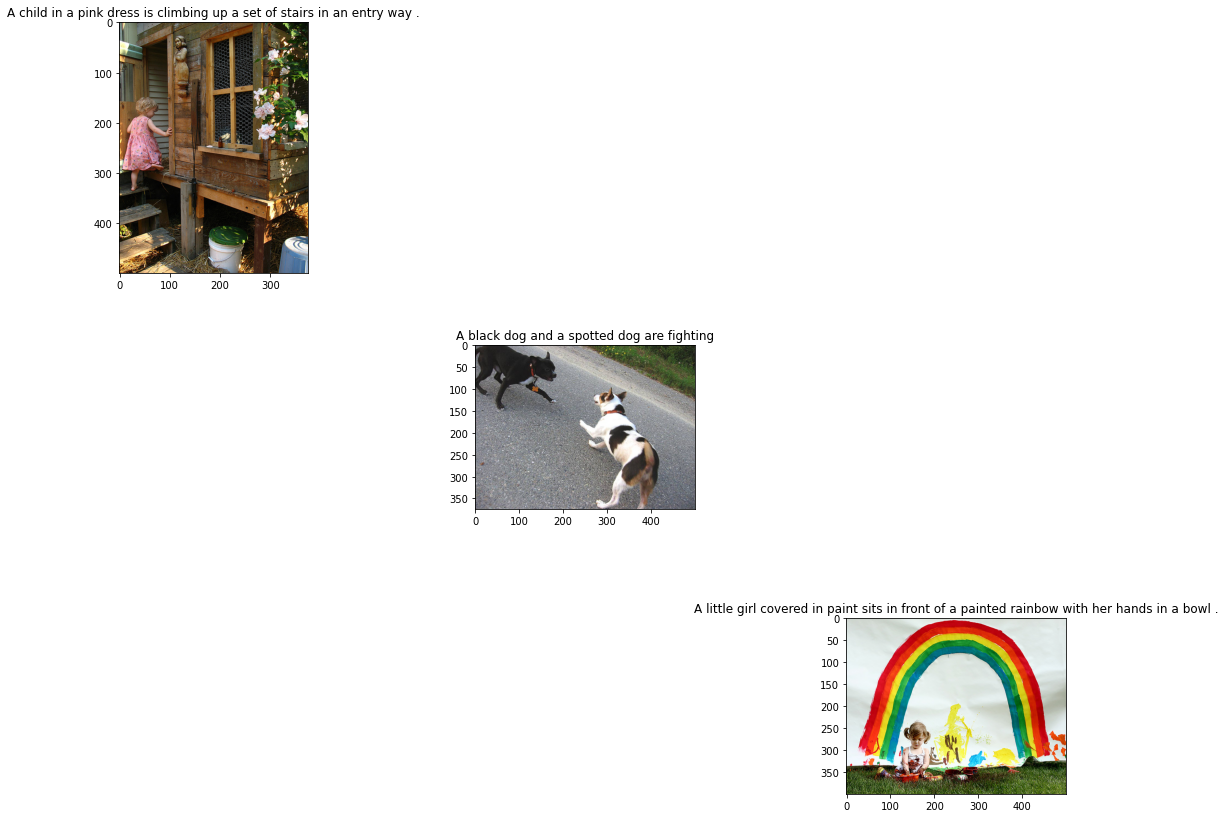

In [ ]:
def display_samples(df, columns=4, rows=3):
    fig=plt.figure(figsize=(5*columns, 4*rows))

    for i in range(0, columns*rows, 5):
        image_path = df.loc[i,'image']
        image_id = df.loc[i,'caption']
        img = cv2.imread(f'/content/drive/MyDrive/EDI2021/Images/{image_path}')
        #img = cv2.imread(f'/content/drive/MyDrive/EDI2021/Our_Test/{image_path}')
        
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        fig.add_subplot(rows, columns, i+1)
        plt.title(image_id)
        plt.imshow(img)
    
    plt.tight_layout()

display_samples(df)

In [ ]:
def preprocess(image_path):
    # Convert all the images to size 299x299 as expected by the inception v3 model
    img = image.load_img(image_path, target_size=(299, 299))
    # Convert PIL image to numpy array of 3-dimensions
    x = image.img_to_array(img)
    # Add one more dimension
    x = np.expand_dims(x, axis=0)
    # preprocess the images using preprocess_input() from inception module
    x = preprocess_input(x)
    return x

In [ ]:
# Load the inception v3 model
model = InceptionV3(weights='imagenet')

In [ ]:
model_new = Model(model.input, model.layers[-2].output)

# Run only once...

In [ ]:
# Function to encode a given image into a vector of size (2048, )
def encode(image):
    image = preprocess(image) # preprocess the image
    fea_vec = model_new.predict(image) # Get the encoding vector for the image
    #print(fea_vec)
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1]) # reshape from (1, 2048) to (2048, )
    #print(fea_vec)
    return fea_vec

In [ ]:
encode("/content/drive/MyDrive/EDI2021/Our_Test/Edi_0.jpg").shape

In [ ]:

# Call the funtion to encode all the train images
# This will take a while on CPU - Execute this only once
start = time()
encoding_train = {}
for img in train_img:
    encoding_train[img[len(images):]] = encode(img)
print("Time taken in seconds =", time()-start)


Time taken in seconds = 4.36554479598999


In [ ]:

# Save the bottleneck train features to disk
with open("/content/drive/MyDrive/EDI2021/Pickle/our_encoded_train_images.pkl", "wb") as encoded_pickle:
    pickle.dump(encoding_train, encoded_pickle)

encoded_pickle.close()


In [ ]:
'''
# Call the funtion to encode all the test images - Execute this only once
start = time()
encoding_test = {}
for img in test_img:
    encoding_test[img[len(images):]] = encode(img)
print("Time taken in seconds =", time()-start)
'''

'\n# Call the funtion to encode all the test images - Execute this only once\nstart = time()\nencoding_test = {}\nfor img in test_img:\n    encoding_test[img[len(images):]] = encode(img)\nprint("Time taken in seconds =", time()-start)\n'

In [ ]:
'''
# Save the bottleneck test features to disk
with open("/content/drive/MyDrive/EDI2021/Pickle/encoded_test_images.pkl", "wb") as encoded_pickle:
    pickle.dump(encoding_test, encoded_pickle)

encoded_pickle.close()
'''

'\n# Save the bottleneck test features to disk\nwith open("/content/drive/MyDrive/EDI2021/Pickle/encoded_test_images.pkl", "wb") as encoded_pickle:\n    pickle.dump(encoding_test, encoded_pickle)\n\nencoded_pickle.close()\n'

In [ ]:
train_features = pickle.load(open("/content/drive/MyDrive/EDI2021/Pickle/encoded_train_images.pkl", "rb"))
print('Photos: train=%d' % len(train_features))

Photos: train=6000


In [ ]:
# Create a list of all the training captions
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)
len(all_train_captions)

30000

In [ ]:
# Consider only words which occur at least 10 times in the corpus
word_count_threshold = 10
#word_count_threshold = 2
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed words %d -> %d' % (len(word_counts), len(vocab)))

preprocessed words 7578 -> 1651


In [ ]:
ixtoword = {}
wordtoix = {}

ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

In [ ]:
vocab_size = len(ixtoword) + 1 # one for appended 0's
vocab_size

1652

In [ ]:
# convert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
	all_desc = list()
	for key in descriptions.keys():
		[all_desc.append(d) for d in descriptions[key]]
	return all_desc

# calculate the length of the description with the most words
def max_length(descriptions):
	lines = to_lines(descriptions)
	return max(len(d.split()) for d in lines)

# determine the maximum sequence length
max_length = max_length(train_descriptions)
print('Description Length: %d' % max_length)

Description Length: 34


In [ ]:
# data generator, intended to be used in a call to model.fit_generator()
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[key+'.jpg']
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            # yield the batch data
            if n==num_photos_per_batch:
                yield [array(X1), array(X2)], array(y)
                X1, X2, y = list(), list(), list()
                n=0

In [ ]:
# Load Glove vectors
glove_dir = "/content/drive/MyDrive/EDI2021/Glove/"
embeddings_index = {} # empty dictionary
f = open(os.path.join(glove_dir, 'glove.6B.200d.txt'), encoding="utf-8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [ ]:
embedding_dim = 200

# Get 200-dim dense vector for each of the 10000 words in out vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in wordtoix.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector

In [ ]:
embedding_matrix.shape

(1652, 200)

In [ ]:
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
model = Model(inputs=[inputs1, inputs2], outputs=outputs)

In [ ]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 34)]         0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 34, 200)      330400      input_6[0][0]                    
__________________________________________________________________________________________________
dropout_2 (Dropout)             (None, 2048)         0           input_5[0][0]                    
____________________________________________________________________________________________

In [ ]:
model.layers[2]

In [ ]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [ ]:
epochs = 10
number_pics_per_bath = 3
steps = len(train_descriptions)//number_pics_per_bath

In [ ]:
for i in range(10):
    generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_bath)
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save('/content/drive/MyDrive/EDI2021/model_test/our_model_' + str(i) + '.h5')

 1/14 [=>............................] - ETA: 0s - loss: 4.3160

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


14/14 [==============================] - 1s 61ms/step - loss: 1.7073


In [ ]:
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_bath)
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save('/content/drive/MyDrive/EDI2021/Models/model_' + str(i) + '.h5')

2000/2000 [==============================] - 192s 94ms/step - loss: 4.1310


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


2000/2000 [==============================] - 183s 92ms/step - loss: 2.7257


In [ ]:
#model.load_weights("/content/drive/MyDrive/EDI2021/model_test/model_9.h5")
model.load_weights("/content/drive/MyDrive/EDI2021/Models/model_9.h5")

In [ ]:
with open("/content/drive/MyDrive/EDI2021/Pickle/encoded_our_test_images.pkl", "rb") as encoded_pickle:
#with open("/content/drive/MyDrive/EDI2021/Pickle/our_encoded_train_images.pkl", "rb") as encoded_pickle:
    our_encoding_test = pickle.load(encoded_pickle)

In [ ]:
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

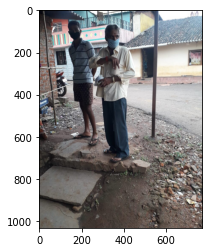

Greedy: man in jeans is sitting on bench


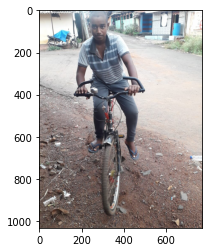

Greedy: man wearing helmet and leather jacket is riding bicycle on the street


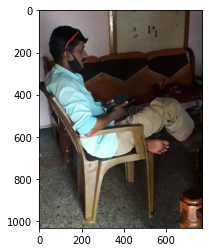

Greedy: man in white shirt is sitting on bench reading book


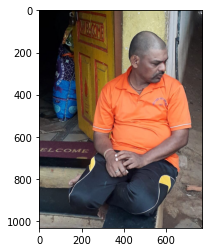

Greedy: man in white shirt is sitting on bed


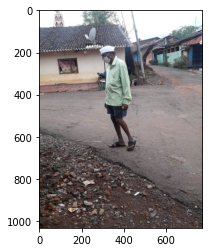

Greedy: man is standing on the beach near the water


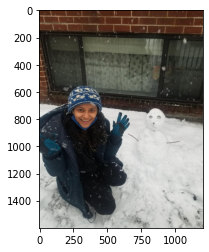

Greedy: child in red hat is shoveling snow covered mountain


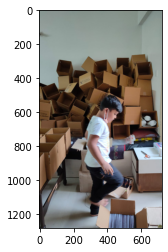

Greedy: man in white shirt is sitting on bench with his dog


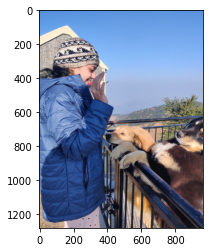

Greedy: man in white shirt is sitting on bench


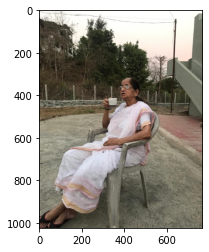

Greedy: man in white shirt is sitting on bench


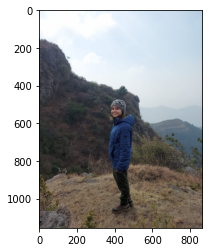

Greedy: man is standing on top of cliff overlooking the ocean


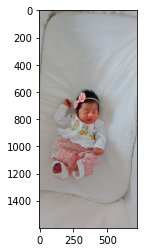

Greedy: baby is sitting on bed


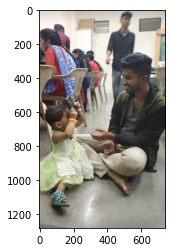

Greedy: man in white shirt is sitting on the subway


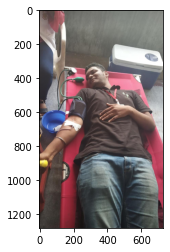

Greedy: two women are sitting on the edge of bus


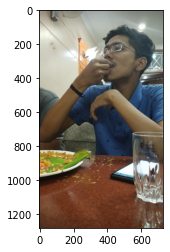

Greedy: man with beard and beard is sitting on bed


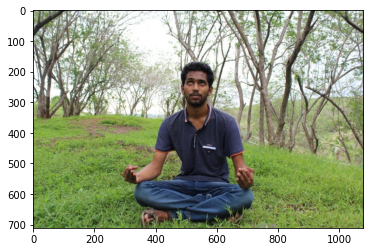

Greedy: man in blue shirt and jeans stands on park bench


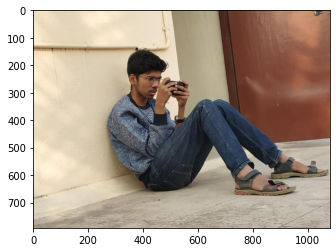

Greedy: man in white shirt is sitting on the curb near an


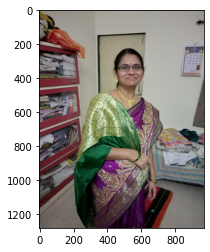

Greedy: man in black shirt is standing next to woman in red shirt


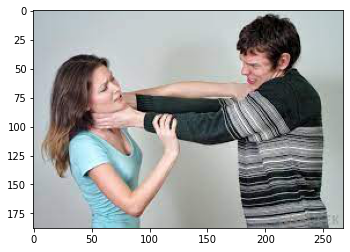

Greedy: little boy in red shirt is jumping on bed


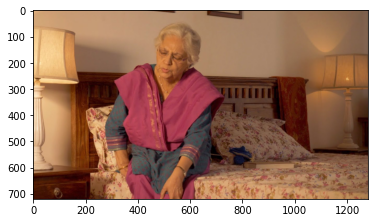

Greedy: man in white shirt is sleeping on bench


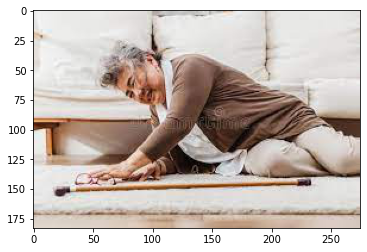

Greedy: boy is sitting on bed


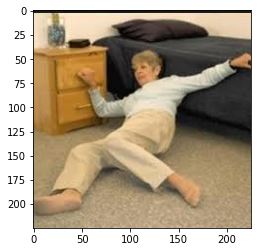

Greedy: boy in blue shirt and jeans is jumping on bed


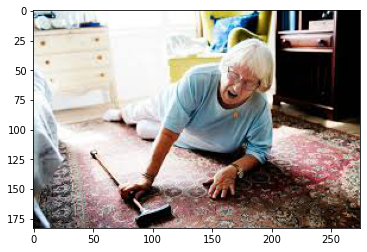

Greedy: man in white shirt is sitting on bench reading book


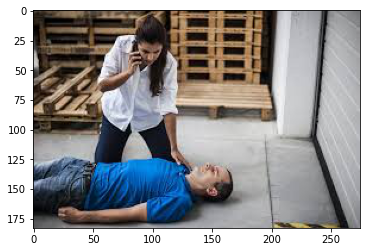

Greedy: two boys are sitting on the floor of wooden bench


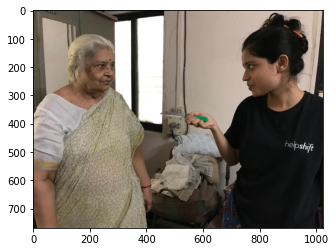

Greedy: man in white shirt is sleeping on bed


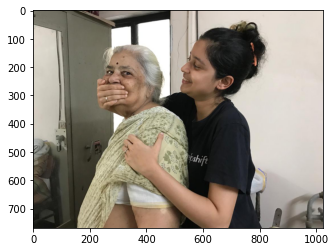

Greedy: man in white shirt is standing next to man in white shirt


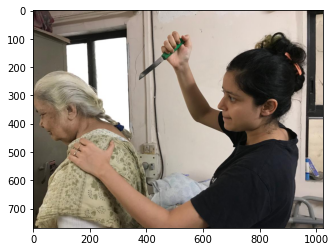

Greedy: man in white shirt is sitting on the ground reading book


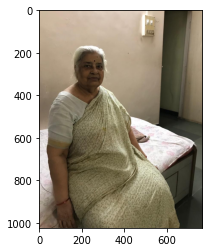

Greedy: man in white shirt is sleeping on bench


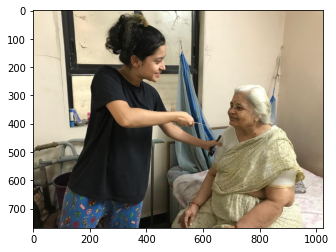

Greedy: man in white shirt is standing by the railing


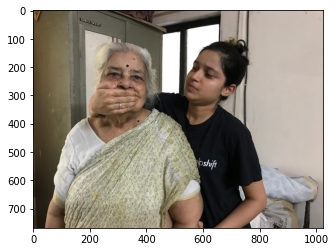

Greedy: man in white shirt is standing next to man in white shirt


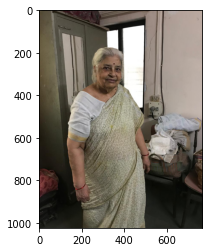

Greedy: man in white shirt is sitting on bed


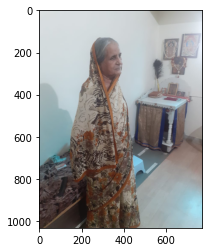

Greedy: man in red shirt is standing in front of large fountain


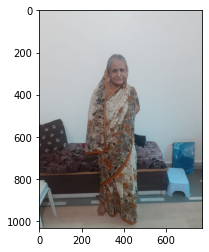

Greedy: man in white shirt is sitting on the edge of boat


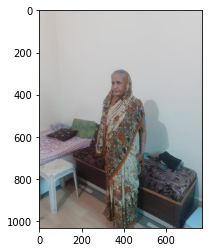

Greedy: man in white shirt is standing on the street


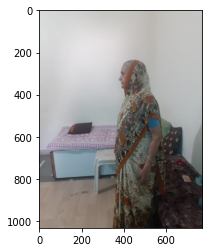

Greedy: man in white shirt is standing by the railing near the water


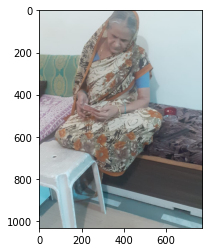

Greedy: man in white shirt is sitting on bench


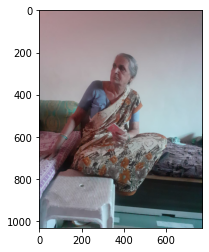

Greedy: man in white shirt is sitting on the edge of wooden table


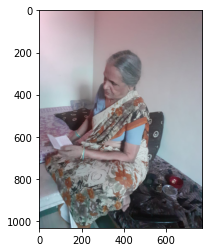

Greedy: man in white shirt is sitting on the curb


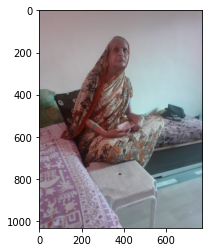

Greedy: man sits on the edge of boat with his dog


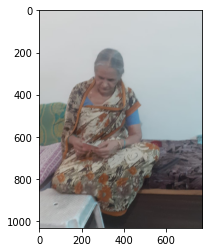

Greedy: man is sitting on the deck next to woman in white shirt


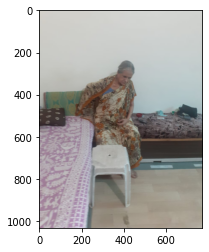

Greedy: man in white shirt is sitting on bench reading book


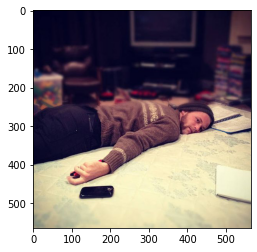

Greedy: man in white shirt is sleeping on bench


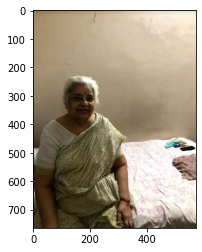

Greedy: man and woman sit on the edge of the side of the water


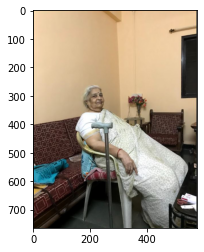

Greedy: man in white shirt is sitting on the bed


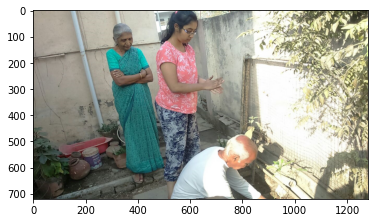

Greedy: boy in red shirt is sitting on bed


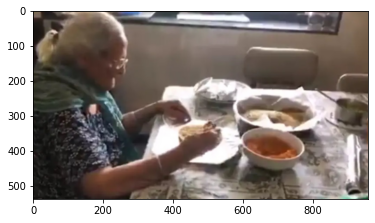

Greedy: man in white shirt is sitting on the edge of fountain


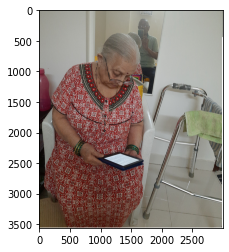

Greedy: man in white shirt is sitting on the curb near the street


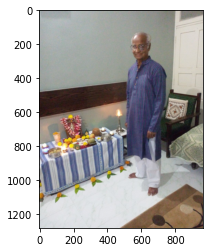

Greedy: man in white shirt is sitting on bench reading book


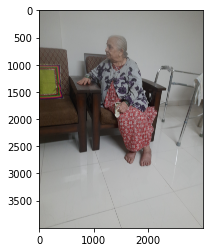

Greedy: man in white shirt is sitting on bench reading book


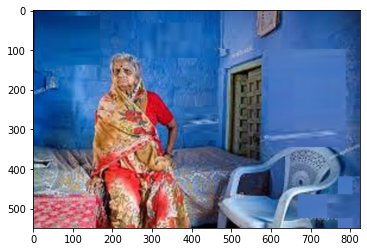

Greedy: man in white shirt is standing by window


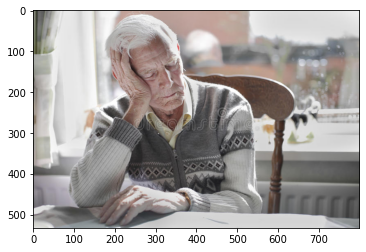

Greedy: man with beard and beard is sitting on the phone


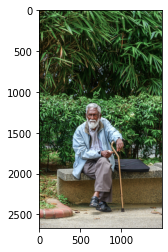

Greedy: man in blue shirt is sitting on bench


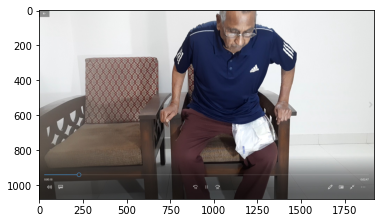

Greedy: boy in blue shirt is sitting on bed


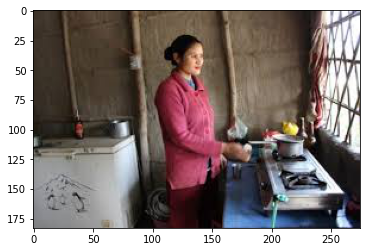

Greedy: man in white shirt is sitting on bench reading book


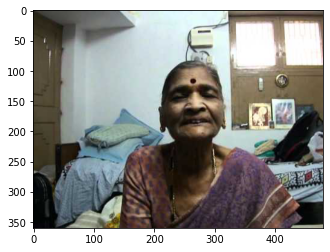

Greedy: man with beard and beard is sitting on bed


In [ ]:
#z = 4
for z in range(54):
    pic = list(our_encoding_test.keys())[z]
    image = our_encoding_test[pic].reshape((1,2048))
    x = plt.imread(our_images+pic)
    #x = plt.imread(images+pic)
    plt.imshow(x)
    plt.show()
    print("Greedy:", greedySearch(image))

In [ ]:
with open("/content/drive/MyDrive/EDI2021/Pickle/encoded_test_images.pkl", "rb") as encoded_pickle:
    encoding_test = pickle.load(encoded_pickle)

In [ ]:
print(encoding_test)

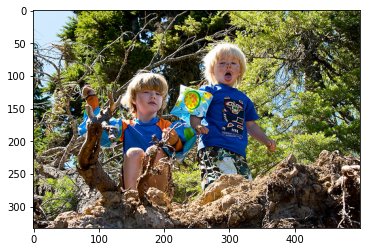

Greedy: child in red shirt and jeans is swinging on rope swing


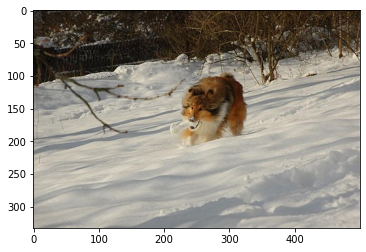

Greedy: dog runs through the snow


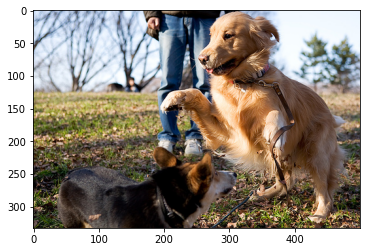

Greedy: two dogs play together in the grass


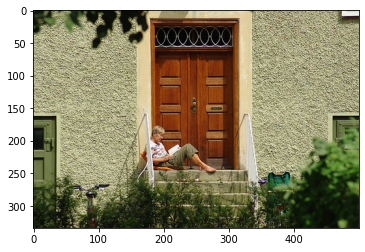

Greedy: man in white shirt is sitting on bench with his shoes on


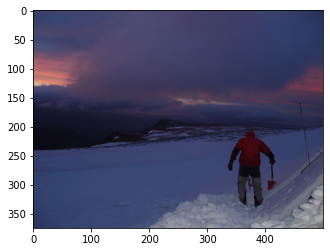

Greedy: man in red jacket is climbing up snowy mountain


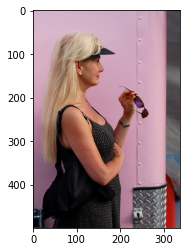

Greedy: woman in white shirt is standing in front of the


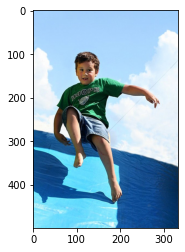

Greedy: boy in red shirt is jumping into the pool


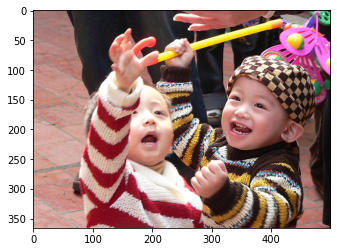

Greedy: baby in red shirt is sitting on bed with toy in his hand


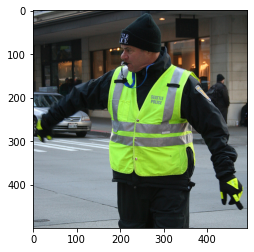

Greedy: man in red shirt is walking past an old man in white shirt


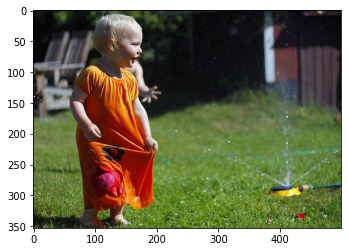

Greedy: two boys are sitting on the grass


In [ ]:
#z = 4
for z in range(10):
    pic = list(encoding_test.keys())[z]
    image = encoding_test[pic].reshape((1,2048))
    x = plt.imread(images+pic)
    plt.imshow(x)
    plt.show()
    print("Greedy:", greedySearch(image))

# User Input part...

In [ ]:
#all the our images
our_images = "/content/drive/MyDrive/EDI2021/Our_Test/"

our_img = glob.glob(our_images + '*.jpg')
print(len(our_img))

54


In [ ]:
# test data
our_test_images_file = "/content/drive/MyDrive/EDI2021/our_test.txt"

our_test_images = set(open(our_test_images_file, 'r').read().strip().split('\n'))

our_test_img = []

for i in our_img:                               
    if i[len(our_images):] in our_test_images:      
        our_test_img.append(i)       

print(len(our_test_img))        

54


In [ ]:
# Call the funtion to encode all the our test images - Execute this only once
start = time()
encoding_test = {}
for img in our_test_img:
    encoding_test[img[len(our_images):]] = encode(img)
print("Time taken in seconds =", time()-start)

Time taken in seconds = 52.764742612838745


In [ ]:
# Save the bottleneck our test features to disk
with open("/content/drive/MyDrive/EDI2021/Pickle/encoded_our_test_images.pkl", "wb") as encoded_pickle:
    pickle.dump(encoding_test, encoded_pickle)

encoded_pickle.close()